In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

%matplotlib inline

In [2]:
df = pd.read_csv('Canadian_elections_2019.csv')

In [3]:
df.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [4]:
df.shape

(2133, 3)

# Removing Null Values and Duplicates

In [5]:
df.isnull().sum()

sentiment             0
negative_reason    1126
text                  0
dtype: int64

In [6]:
df_main = df.drop(['negative_reason'],axis=1)

In [7]:
df_main.isnull().sum()

sentiment    0
text         0
dtype: int64

In [8]:
df_main.duplicated().sum()

0

# Calculating Impurity In the Data

In [9]:
#Calculating the impurity in the text.

import re 

expression = re.compile(r'[&#;?:^${}\[\]\\]')
def impurity(text,min_len=10):
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(expression.findall(text))/len(text)

In [10]:
df_main['impurity_score'] = df_main['text'].apply(impurity, min_len=10)

In [11]:
df_main.head()

,sentiment,text,impurity_score
0,negative,"b""@RosieBarton So instead of your suggestion, ...",0.028070
1,positive,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",0.072000
2,negative,"b""#Brantford It's going to cost YOU $94 BILLIO...",0.045802
3,positive,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",0.094828
4,negative,"b""#Canada #taxpayers are sick &amp; tired of h...",0.038835


In [12]:
df_main[['text','impurity_score']].sort_values(by='impurity_score',ascending=False).head(5)

,text,impurity_score
2089,b'With the exception of people who are deep in...,0.207609
1158,b'All of this + GO VOTE!\n\n\xf0\x9f\x97\xb3 \...,0.182609
744,b'@CelMarJH He just loves his costumes so much...,0.181034
559,b'#AnxiousAndrew isn\xe2\x80\x99t at all threa...,0.158672
96,"b""@JustinTrudeau @votekaiser @VBadawey @Libera...",0.156364


In [13]:
df_main['impurity_score'].describe()  

count    2133.000000
mean        0.040454
std         0.025381
min         0.003115
25%         0.022581
50%         0.034921
75%         0.052326
max         0.207609
Name: impurity_score, dtype: float64

We got an average impurity 4.0% and max impurity of 20% for the text in the data

In [14]:
#Length of the Tweets Distribution
df_main['length'] = df_main['text'].str.len()

In [15]:
df_main['length'].describe()

count    2133.000000
mean      211.474918
std        83.811137
min        28.000000
25%       146.000000
50%       209.000000
75%       282.000000
max       920.000000
Name: length, dtype: float64

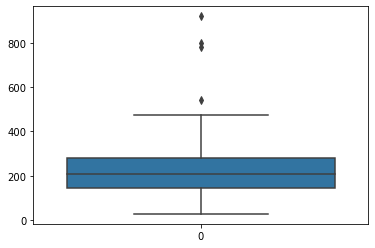

In [16]:
import seaborn as sns

sns.boxplot(data=df_main['length'])

# Text Cleaning

In [17]:
# Function to clean the text.

import re,html
def clean(text):
    #tags like <tag>
    text = re.sub(r'<[^<>]*>', ' ',text)
    #Markdown Urls
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)',r'\1',text)
    #Remove Punctuation
    text = re.sub(r'([!?,])\1+', r'\1', text)
    #Remove all URL's
    text = re.sub(r'http.*', ' ', text)
    #Remove @
    text = re.sub(r'@\w*', ' ', text)
    #text or code in brackets
    text = re.sub(r'\[[^\[\]]*\]',' ',text)
    # remove b"
    text = text.replace('b\"',' ') 
    # remove b'
    text = text.replace("b\'",' ') 
    # remove \\n
    text = text.replace('\\n',' ')
    #Remove &amp
    text = text.replace('&amp',' ') 
    # remove UTF-8 code like \\xe2
    text = re.sub(r'(\\x(.){2})', ' ',text) 
    #Standalone sequences for specials
    text = re.sub(r'(?:^|\s)[;.\'\"&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ',text)
    #stand alone sequence of hyphens 
    text= re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ',text)
    # Sequence of white spaces
    text = re.sub(r'\s+',' ',text)
    return text.strip()

In [18]:
def _normalize_contractions_text(text, contractions):
    """
    This function normalizes english contractions.
    """
    new_token_list = []
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in contractions:
            replacement = contractions[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    sentence = " ".join(new_token_list).strip(" ")
    return sentence

In [19]:
def normalize_contractions(sentence_list):
    contraction_list = json.loads(open('english_contractions.json', 'r').read())
    norm_sents = []
    print("Normalizing contractions")
    for sentence in tqdm(sentence_list):
        norm_sents.append(_normalize_contractions_text(sentence, contraction_list))
    return norm_sents

contraction_list = json.loads(open('english_contractions.json', 'r').read())

In [20]:
df_main['clean_text'] = df_main['text'].map(clean)

In [21]:
df_main['clean_text'] = normalize_contractions(df_main['clean_text'])

100%|███████████████████████████████████████████████████████████████████████████| 2133/2133 [00:00<00:00, 36879.96it/s]

Normalizing contractions


In [22]:
df_main['impurity_score'] = df_main['clean_text'].apply(impurity, min_len=10)

In [23]:
df_main[['clean_text','impurity_score']].sort_values(by='impurity_score',ascending=False).head(5)

,clean_text,impurity_score
42,I cannot even... #cdnpoli #yyj #qcpoli #onpoli...,0.132143
570,#Canadian Politics Today #elxn43 #CANADA #POLI...,0.116935
2132,Zing. #NDP #elxn43,0.111111
1292,Do it #YEG #cndpoli #elxn43,0.111111
749,#giveusdata #cdnpoli #bcpoli #vanpoli #YVRRE #...,0.104167


In [24]:
df_main['impurity_score'].describe() 

count    2133.000000
mean        0.023963
std         0.017305
min         0.000000
25%         0.011583
50%         0.019920
75%         0.032258
max         0.132143
Name: impurity_score, dtype: float64

Average impurity is reduced from 4.0% to 2.3% and max impurity is reduced from 20% to 13%

In [25]:
import nltk as nt
from nltk.corpus import stopwords
nt.download('stopwords')
sw = stopwords.words( 'english' )
my_list = ['I','The',"b'It",'On']
sw = sw + my_list
def remove_stopwords(text):
    l = []
    for i in text.split():
        if i not in sw:
            l.append(i.strip('\'\"'))
    return l

[nltk_data] Downloading package stopwords to C:\Users\Akash
[nltk_data]     Guje\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
df_main['tokens'] = df_main['clean_text'].apply(remove_stopwords)

In [27]:
df_main

,sentiment,text,impurity_score,length,clean_text,tokens
0,negative,"b""@RosieBarton So instead of your suggestion, ...",0.029740,285,"So instead of your suggestion, how about we ag...","[So, instead, suggestion,, agree, #Canadian, #..."
1,positive,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",0.074074,125,#AllWomanSpacewalk it is real! #EtobicokeNorth...,"[#AllWomanSpacewalk, real!, #EtobicokeNorth, #..."
2,negative,"b""#Brantford It's going to cost YOU $94 BILLIO...",0.047619,131,#Brantford It is going to cost YOU $94 BILLION...,"[#Brantford, It, going, cost, YOU, $94, BILLIO..."
3,positive,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",0.061728,116,#Canada #CanadaElection2019 #CanadaVotes #elxn...,"[#Canada, #CanadaElection2019, #CanadaVotes, #..."
4,negative,"b""#Canada #taxpayers are sick &amp; tired of h...",0.035857,309,#Canada #taxpayers are sick tired of having th...,"[#Canada, #taxpayers, sick, tired, hard, earne..."
...,...,...,...,...,...,...
2128,negative,b'You know he was doing a good enough job smea...,0.024631,245,You know he was doing a good enough job smeari...,"[You, know, good, enough, job, smearing, campa..."
2129,negative,b'You missed the comment. Deflecting the issue...,0.017316,284,You missed the comment. Deflecting the issue d...,"[You, missed, comment., Deflecting, issue, ans..."
2130,positive,b'Your daily reminder:\n@theJagmeetSingh endor...,0.079545,134,Your daily reminder: endorses strategic voting...,"[Your, daily, reminder:, endorses, strategic, ..."
2131,negative,b'Yup...not going to reopen the abortion debat...,0.035294,129,Yup...not going to reopen the abortion debate....,"[Yup...not, going, reopen, abortion, debate......"


In [28]:
from collections import Counter

counter = Counter()

df_main['tokens'].map(counter.update)

0       None
1       None
2       None
3       None
4       None
        ... 
2128    None
2129    None
2130    None
2131    None
2132    None
Name: tokens, Length: 2133, dtype: object

# MostCommon Words in the 2019 Election data

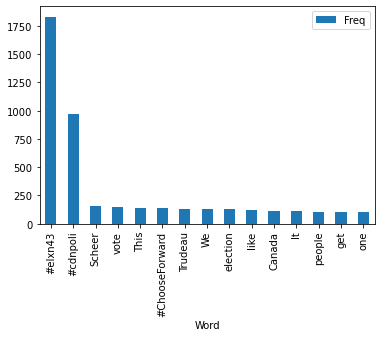

In [29]:
most_common = pd.DataFrame(counter.most_common(15),columns=['Word','Freq'])
most_common.plot(kind='bar',x='Word',y='Freq')

Text(0.5, 1.0, 'Word Cloud on Total Clean_text')

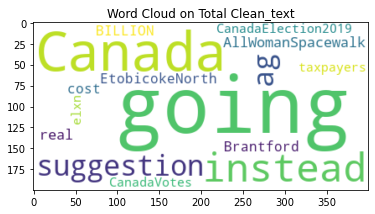

In [30]:
from wordcloud import WordCloud

text = str(df_main['clean_text'])
wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on Total Clean_text')

Text(0.5, 1.0, 'Word Cloud on Total Counter Values')

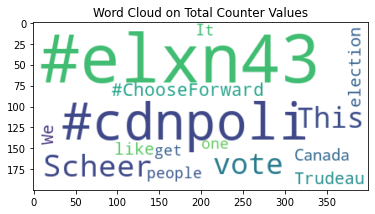

In [31]:
from wordcloud import WordCloud

wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate_from_frequencies(counter)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on Total Counter Values')

Text(0.5, 1.0, 'Word Cloud on Positive Tweets')

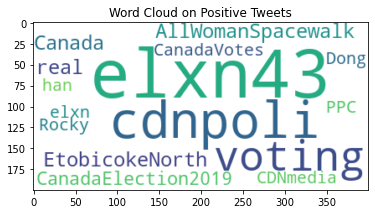

In [32]:
text = str(df_main.query("sentiment == 'positive'")['clean_text'])
wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on Positive Tweets')

Text(0.5, 1.0, 'Word Cloud on Negative Tweets')

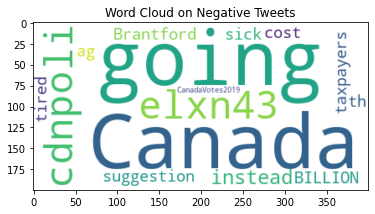

In [33]:
text = str(df_main.query("sentiment == 'negative'")['clean_text'])
wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on Negative Tweets')

In [34]:
df_positive = df_main.query("sentiment == 'positive'")

In [35]:
df_positive.shape

(1127, 6)

In [36]:
counter = Counter()
df_positive['tokens'].map(counter.update)

1       None
3       None
6       None
7       None
10      None
        ... 
2120    None
2123    None
2127    None
2130    None
2132    None
Name: tokens, Length: 1127, dtype: object

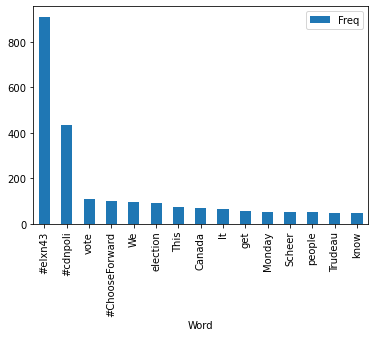

In [37]:
most_common_positive = pd.DataFrame(counter.most_common(15),columns=['Word','Freq'])
most_common_positive.plot(kind='bar',x='Word',y='Freq')

In [38]:
df_positive = df_main.query("sentiment == 'negative'")

In [39]:
df_positive.shape

(1006, 6)

In [40]:
counter = Counter()
df_positive['tokens'].map(counter.update)

0       None
2       None
4       None
5       None
8       None
        ... 
2125    None
2126    None
2128    None
2129    None
2131    None
Name: tokens, Length: 1006, dtype: object

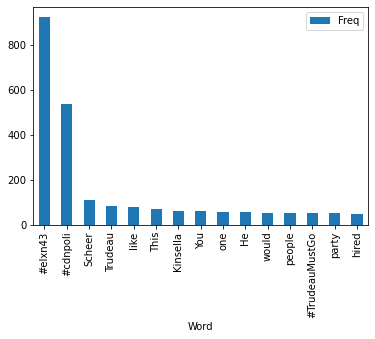

In [41]:
most_common_negative = pd.DataFrame(counter.most_common(15),columns=['Word','Freq'])
most_common_negative.plot(kind='bar',x='Word',y='Freq')

In [42]:
df_main

,sentiment,text,impurity_score,length,clean_text,tokens
0,negative,"b""@RosieBarton So instead of your suggestion, ...",0.029740,285,"So instead of your suggestion, how about we ag...","[So, instead, suggestion,, agree, #Canadian, #..."
1,positive,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",0.074074,125,#AllWomanSpacewalk it is real! #EtobicokeNorth...,"[#AllWomanSpacewalk, real!, #EtobicokeNorth, #..."
2,negative,"b""#Brantford It's going to cost YOU $94 BILLIO...",0.047619,131,#Brantford It is going to cost YOU $94 BILLION...,"[#Brantford, It, going, cost, YOU, $94, BILLIO..."
3,positive,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",0.061728,116,#Canada #CanadaElection2019 #CanadaVotes #elxn...,"[#Canada, #CanadaElection2019, #CanadaVotes, #..."
4,negative,"b""#Canada #taxpayers are sick &amp; tired of h...",0.035857,309,#Canada #taxpayers are sick tired of having th...,"[#Canada, #taxpayers, sick, tired, hard, earne..."
...,...,...,...,...,...,...
2128,negative,b'You know he was doing a good enough job smea...,0.024631,245,You know he was doing a good enough job smeari...,"[You, know, good, enough, job, smearing, campa..."
2129,negative,b'You missed the comment. Deflecting the issue...,0.017316,284,You missed the comment. Deflecting the issue d...,"[You, missed, comment., Deflecting, issue, ans..."
2130,positive,b'Your daily reminder:\n@theJagmeetSingh endor...,0.079545,134,Your daily reminder: endorses strategic voting...,"[Your, daily, reminder:, endorses, strategic, ..."
2131,negative,b'Yup...not going to reopen the abortion debat...,0.035294,129,Yup...not going to reopen the abortion debate....,"[Yup...not, going, reopen, abortion, debate......"


# Calculating Tf-IDf

In [43]:
counter = Counter()

df_main['tokens'].map(counter.update)

0       None
1       None
2       None
3       None
4       None
        ... 
2128    None
2129    None
2130    None
2131    None
2132    None
Name: tokens, Length: 2133, dtype: object

In [44]:
idf_df=pd.DataFrame.from_dict(counter,orient='index', columns=['Freq'])  # Getting the Frequencies of Each word.

In [45]:
idf_df.head(5)

,Freq
So,43
instead,7
"suggestion,",1
agree,17
#Canadian,4


In [46]:
df.index

RangeIndex(start=0, stop=2133, step=1)

In [47]:
idf_df.shape

(11521, 1)

In [48]:
idf_df['Freq'].describe()

count    11521.000000
mean         3.050256
std         20.549926
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1832.000000
Name: Freq, dtype: float64

In [49]:
idf_df['idf']= np.log(len(df_main)/idf_df['Freq'])+0.1

In [50]:
idf_df['idf'].describe()

count    11521.000000
mean         7.309645
std          0.801913
min          0.252121
25%          7.072138
50%          7.765285
75%          7.765285
max          7.765285
Name: idf, dtype: float64

In [51]:
idf_df['tfidf'] = idf_df['Freq'] * idf_df['idf']

In [52]:
idf_df = idf_df.query('Freq > 2')  # Considering words whose frequency is greater than 2

In [53]:
idf_df.nsmallest(10,'tfidf')[['idf','Freq']]

,idf,Freq
#abortion,6.666672,3
#EtobicokeNorth,6.666672,3
Cannot,6.666672,3
police,6.666672,3
victims,6.666672,3
double,6.666672,3
Full,6.666672,3
QC,6.666672,3
Ford's,6.666672,3
bid,6.666672,3


Some less frequence words in the document but has more meaning refering to the topic Elections.

# Data Mining

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english")
preprocessor = vectorizer.build_preprocessor()
tokenizer = vectorizer.build_tokenizer()

In [55]:
#BOW

def bag_of_words(tweets):
    tokenized = tokenizer(preprocessor(tweets))
    
    words = {}
    
    for i in tokenized:
        if i in words.keys():
            words[i]+=1
        else:
            words[i] = 1
    return words

In [56]:
def party(tweets):
    
    bow = bag_of_words(tweets)
    
        liberals = ["justin","justintrudeau","lpc","liberalparty","Forward","justin4pm","teamtrudeau","liberal","liberals",'timeforchange','#ChooseForward','voteliberals','justnotready','liberal_party','trudeau','trudeaumania']
    conservatives = ['conservativeparty','Scheer','#AndrewScheer','#Scheer','cpc','conservative','conservatives']
    ndp = ['#JagmeetSingh','JagmeetSingh','#ndp','@theJagmeetSingh','ndp','npd','NDP','#UpRiSingh','votendp','ndpleader','ndpcanada']
    other_parties = [ 'green','greenparty', 'gpc','canadiangreens','greenpartyofcanada','@peoplespca','elizabethmay','votegreen','polqc','paysqc','jevotebloc','ppc','bloc','blocqc','greenpeace']
    other_election_topics = ["cdnpoli","#cdnpoli","elxn44","#elxn44","vote","#EtobicokeNorth",'#Alberta','#Ontario','QC']
    party = {"liberals":0,"conservatives":0,"ndp":0,"other_parties":0,"other_election_topics":0,"unrelated tweets":0}
    
    for i in bow:
        if i in liberals:
            party["liberals"]+=bow[i]
            
        if i in conservatives:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party['conservatives'] += bow[i]
        
        if i in ndp:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party['ndp'] += bow[i]
        
        if i in other_parties:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party['other_parties'] += bow[i]
            
        if i in other_election_topics:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party['other_election_topics'] += bow[i]
            
    party_name = 'unrelated tweets'
    for key in party:
        if party[key] > party[party_name]:
            #update party name value
            party_name = key
    
    
    return party_name

In [57]:
df_main['Party'] = df_main['clean_text'].apply(party)
df_main.sample(10)

,sentiment,text,impurity_score,length,clean_text,tokens,Party
1632,negative,b'Millions of votes thrown away under first-pa...,0.017544,143,Millions of votes thrown away under first-past...,"[Millions, votes, thrown, away, first-past-the...",other_election_topics
669,negative,b'@althiaraj @JustinTrudeau So what. Scheer ha...,0.016667,235,So what. Scheer hasn t given a straight answer...,"[So, what., Scheer, given, straight, answer, i...",unrelated tweets
1290,negative,b'Disappointed with @RosieBarton and her colle...,0.029787,287,Disappointed with and her colleagues in #CDNme...,"[Disappointed, colleagues, #CDNmedia., How, ag...",other_election_topics
728,negative,b'@CBCAlerts @CBCKatie Oh noes @AndrewScheer! ...,0.054054,187,Oh noes ! Did someone lose their teflon coatin...,"[Oh, noes, !, Did, someone, lose, teflon, coat...",other_election_topics
2077,positive,b'Why I am voting #NDP. Liberals have done not...,0.016667,285,Why I am voting #NDP. Liberals have done nothi...,"[Why, voting, #NDP., Liberals, done, nothing, ...",liberals
73,positive,"b""@gauvywonkanobi @bimvision @Bret_Sears @mann...",0.024793,337,#LibConCorruption Here is a snip of Manny_Otta...,"[#LibConCorruption, Here, snip, Manny_Ottawa's...",other_election_topics
860,negative,b'@JustinTrudeau Hahaha move forward together....,0.050000,163,Hahaha move forward together. Youre only in it...,"[Hahaha, move, forward, together., Youre, #elx...",other_election_topics
520,positive,"b""We've got a primer for every York Region rid...",0.028846,129,We have got a primer for every York Region rid...,"[We, got, primer, every, York, Region, riding,...",other_election_topics
1399,positive,b'Helllllooooo #Wellesley Couldn\xe2\x80\x99t ...,0.018868,189,Helllllooooo #Wellesley Couldn t pick a better...,"[Helllllooooo, #Wellesley, Couldn, pick, bette...",unrelated tweets
1048,negative,b'@TheRoyGreenShow @AbigailBimman @globalnews ...,0.004065,336,How pathetic that Conservatives have too hope ...,"[How, pathetic, Conservatives, hope, vote, spl...",liberals


In [58]:
df_main.Party.value_counts() 

other_election_topics    752
unrelated tweets         720
liberals                 310
conservatives            209
other_parties             75
ndp                       67
Name: Party, dtype: int64

In [59]:
df_main.Party.value_counts() 

other_election_topics    752
unrelated tweets         720
liberals                 310
conservatives            209
other_parties             75
ndp                       67
Name: Party, dtype: int64

C:\Users\Akash Guje\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


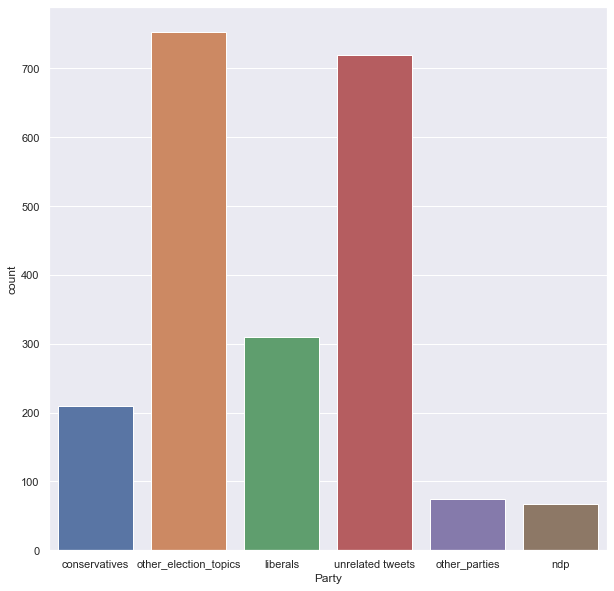

In [60]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.countplot(df_main["Party"])

In [61]:
df_main.sentiment.value_counts() 

positive    1127
negative    1006
Name: sentiment, dtype: int64

In [72]:
#Calculating sentiment through Text Blob
from textblob import TextBlob
sentiment = []
emotions = []

for i in df_main.clean_text:
    s = TextBlob(i)
    sentiment.append(s.sentiment.polarity)
    if s.sentiment.polarity > 0:
        emotions.append("Positive")
    elif s.sentiment.polarity < 0:
        emotions.append("Negative")
    else:
        emotions.append("Neutral")

In [73]:
df_main["Textblob_Sentiments"] = sentiment
df_main["Emotions"] = emotions

In [74]:
df_main[['clean_text','sentiment','Textblob_Sentiments','Emotions']].sample(10)

,clean_text,sentiment,Textblob_Sentiments,Emotions
875,Ctax is meant to change behaviour so change yo...,positive,0.000000,Neutral
1431,I am increasingly convinced that the Trans Mou...,positive,-0.011111,Negative
77,Stephen Harper is back B1tchezzz. Harper will ...,negative,0.168750,Positive
1161,"Allegedly, Scheer hired Warren Kinsella a Toro...",negative,-0.006944,Negative
602,#ndp jagmeet likes the finer things in life li...,negative,0.000000,Neutral
372,Let us choose forward together. #joepeschisoli...,positive,0.000000,Neutral
1748,Question to CPC voters: will you vote CPC and ...,negative,0.000000,Neutral
858,Canadians deserve a better government that CAR...,positive,0.437500,Positive
1337,"For those who are undecided, it is worth re-wa...",negative,0.300000,Positive
1636,"Monday October 21st is #elxn43, and while I do...",positive,0.000000,Neutral


In [75]:
df_main.Emotions.value_counts() 

Positive    990
Neutral     675
Negative    468
Name: Emotions, dtype: int64

Text(0.5, 1.0, 'Sentiments in 2019 election sentiments')

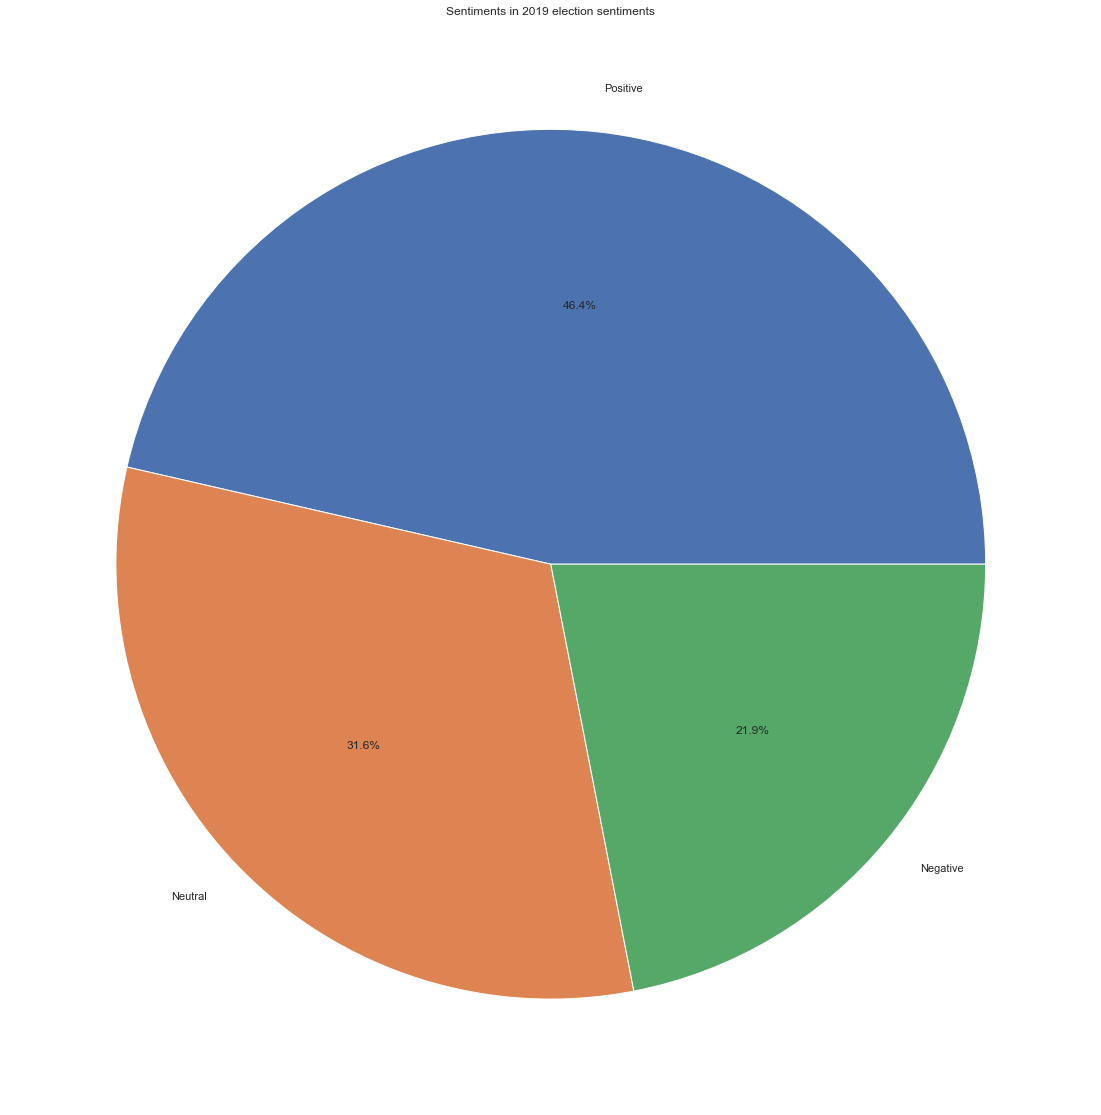

In [76]:
df1 = pd.DataFrame(df_main['Emotions'].value_counts().reset_index())
plt.pie(data=df1,x="Emotions",labels="index",autopct='%.1f%%')
plt.title("Sentiments in 2019 election sentiments")

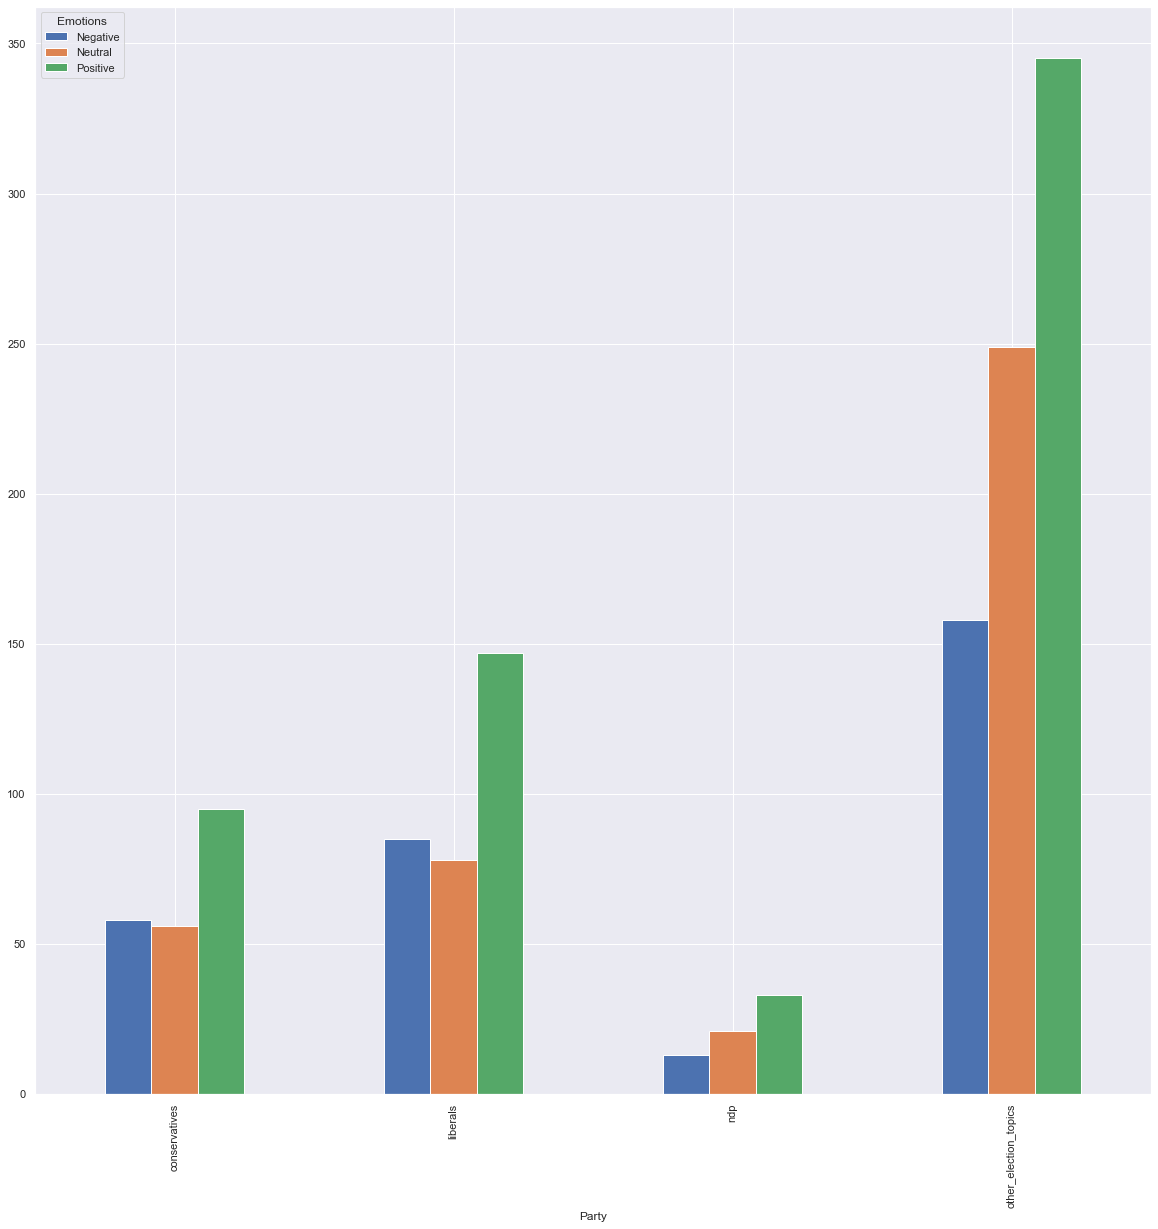

In [77]:
df2= df_main.groupby(['Party'])['Emotions'].value_counts()[:12].unstack().plot(kind='bar',stacked = False)
sns.set(rc = {'figure.figsize':(20,20)})

In [78]:
LPC_tweets = df_main[df_main["Party"]=="liberals"]
ndp_tweets = df_main[df_main["Party"]=="ndp"]
conservatives_tweets = df_main[df_main["Party"]=="conservatives"]
Percentage_pos_lpc = LPC_tweets.Emotions.value_counts()[1]/len(LPC_tweets)*100
Percentage_neg_lpc = LPC_tweets.Emotions.value_counts()[2]/len(LPC_tweets)*100
Percentage_pos_ndp = ndp_tweets.Emotions.value_counts()[1]/len(ndp_tweets)*100
Percentage_neg_ndp = ndp_tweets.Emotions.value_counts()[2]/len(ndp_tweets)*100
Percentage_pos_conservatives = conservatives_tweets.Emotions.value_counts()[1]/len(conservatives_tweets)*100
Percentage_neg_conservatives = conservatives_tweets.Emotions.value_counts()[2]/len(conservatives_tweets)*100

In [79]:
print(f"Percentage of tweets positive on LPC is : {Percentage_pos_lpc} %")
print(f"Percentage of tweets negative on LPC is : {Percentage_neg_lpc} %")
print(f"Percentage of tweets positive on NDP is : {Percentage_pos_ndp} %")
print(f"Percentage of tweets negative on NDP is : {Percentage_neg_ndp} %")
print(f"Percentage of tweets positive on conservatives is : {Percentage_pos_conservatives} %")
print(f"Percentage of tweets negative on conservatives is : {Percentage_neg_conservatives} %")

Percentage of tweets positive on LPC is : 27.419354838709676 %
Percentage of tweets negative on LPC is : 25.161290322580644 %
Percentage of tweets positive on NDP is : 31.343283582089555 %
Percentage of tweets negative on NDP is : 19.402985074626866 %
Percentage of tweets positive on conservatives is : 27.751196172248804 %
Percentage of tweets negative on conservatives is : 26.794258373205743 %


Text(0.5, 1.0, 'Word Cloud on Positive Tweets')

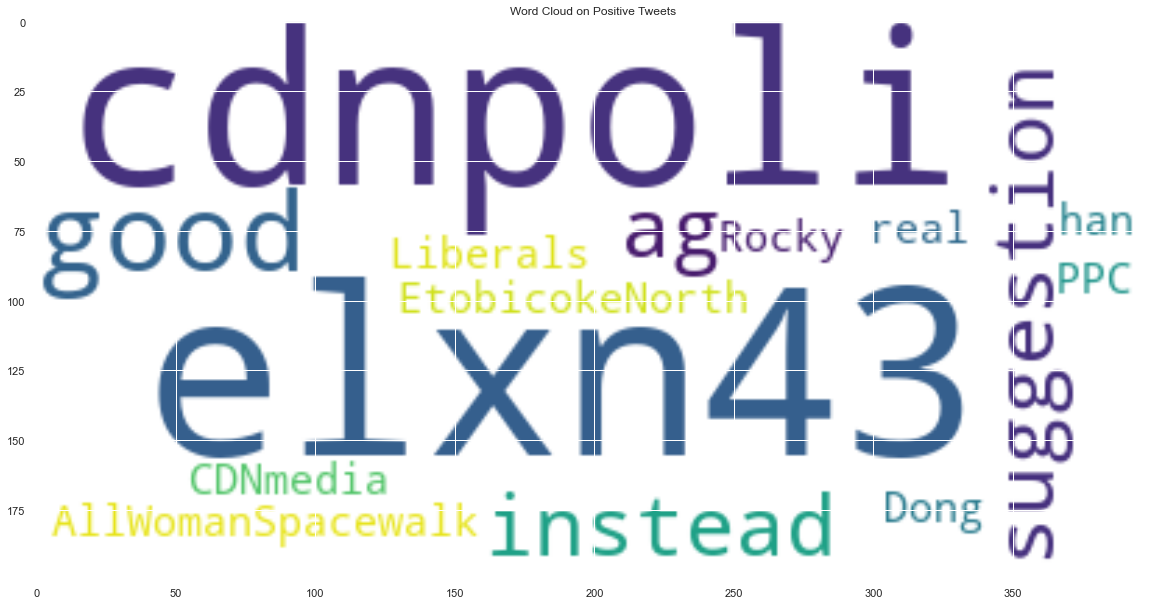

In [80]:
text = str(df_main.query("Emotions == 'Positive'")['clean_text'])
wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on Positive Tweets')

Text(0.5, 1.0, 'Word Cloud on negative Tweets')

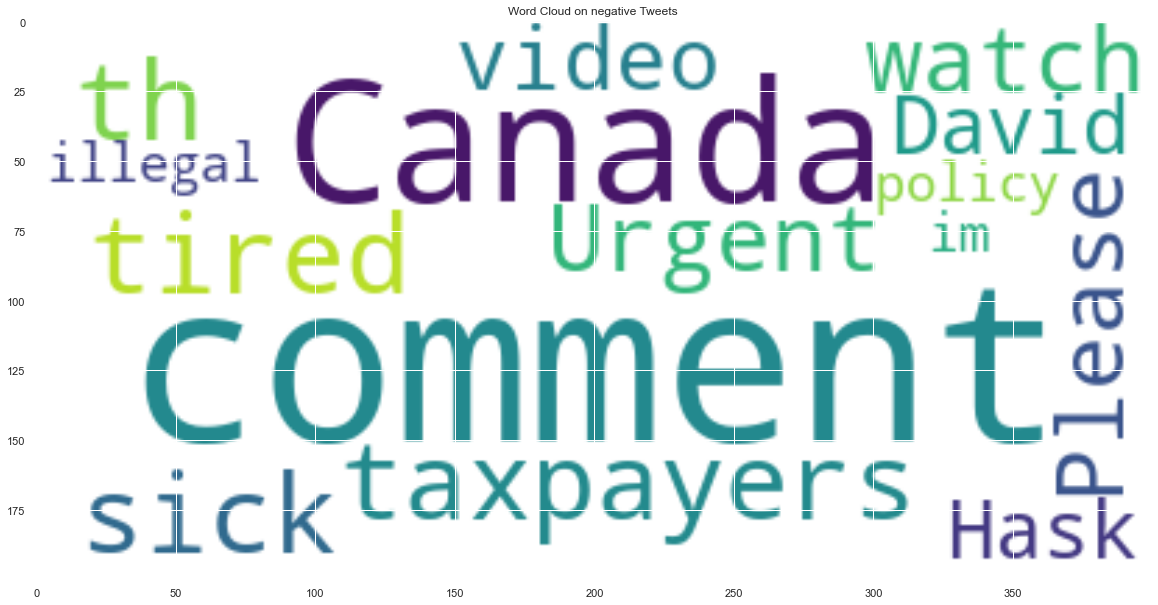

In [81]:
text = str(df_main.query("Emotions == 'Negative'")['clean_text'])
wc = WordCloud(max_words=15,stopwords=sw,background_color='white')
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.title('Word Cloud on negative Tweets')